# Ridge Regression

In [1]:
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import Ridge
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import FunctionTransformer
from sklearn.preprocessing import OneHotEncoder
import pandas as pd
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error


In [14]:
def _encode_dates(X):
    X = X.copy()  # modify a copy of X
    # Encode the date information from the DateOfDeparture columns
    X.loc[:, "year"] = X["date"].dt.year
    X.loc[:, "month"] = X["date"].dt.month
    X.loc[:, "day"] = X["date"].dt.day
    X.loc[:, "weekday"] = X["date"].dt.weekday
    X.loc[:, "hour"] = X["date"].dt.hour

    # Finally we can drop the original columns from the dataframe
    return X.drop(columns=["date"])


def _merge_external_data(X):
    file_path = "external_data1.csv"
    df_ext = pd.read_csv(file_path, parse_dates=["date"])

    X_comb = X.join(df_ext.set_index("date"), on="date", rsuffix="right") 
    X_comb.fillna(method="ffill", inplace=True)
    
    return X_comb.drop(["Unnamed: 0", "date_only"], axis=1)


def get_estimator():
    date_encoder = FunctionTransformer(_encode_dates)
    date_cols = _encode_dates(X_train_comb[["date"]]).columns.tolist()
    scaler = StandardScaler()

    categorical_encoder = OneHotEncoder(handle_unknown="ignore")
    categorical_cols = ["counter_name", "site_name", "wind_dir"]
    numerical_cols = X_train_comb.select_dtypes(include=np.number).columns

    preprocessor = ColumnTransformer(
        [
            ("date", OneHotEncoder(handle_unknown="ignore"), date_cols),
            ("cat", categorical_encoder, categorical_cols),
            #("scaler", scaler, numerical_cols)
        ]
    )

    regressor = Ridge()

    pipe = make_pipeline(date_encoder, preprocessor, regressor)
    pipe.fit(X_train_comb, y_train)
    
    return pipe


In [15]:
import problem

X_train, y_train = problem.get_train_data()
X_test, y_test = problem.get_test_data()

In [16]:
X_train_comb = _merge_external_data(X_train)
pipe = get_estimator()
pipe.fit(X_train_comb, y_train)

Pipeline(steps=[('functiontransformer',
                 FunctionTransformer(func=<function _encode_dates at 0x0000029A32B35670>)),
                ('columntransformer',
                 ColumnTransformer(transformers=[('date',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['year', 'month', 'day',
                                                   'weekday', 'hour']),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['counter_name', 'site_name',
                                                   'wind_dir'])])),
                ('ridge', Ridge())])

In [19]:
X_test_comb = _merge_external_data(X_test)

Train set, RMSE=0.80
Test set, RMSE=0.72
Train set, R^2=0.77
Test set, R^2=0.75


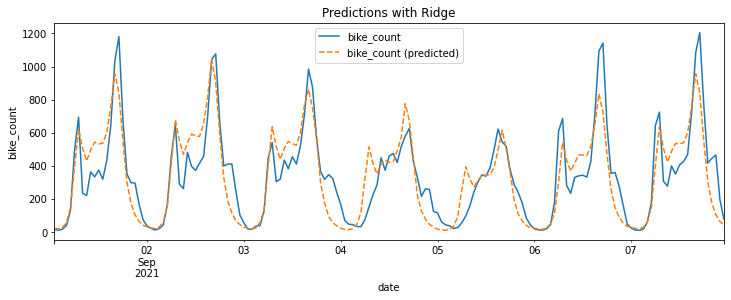

In [28]:
def accuracy(pipe):
    mask = (
        (X_test_comb["counter_name"] == "Totem 73 boulevard de Sébastopol S-N")
        & (X_test_comb["date"] > pd.to_datetime("2021/09/01"))
        & (X_test_comb["date"] < pd.to_datetime("2021/09/08"))
    )

    df_viz = X_test_comb.loc[mask].copy()
    df_viz["bike_count"] = np.exp(y_test[mask.values]) - 1
    df_viz["bike_count (predicted)"] = np.exp(pipe.predict(X_test_comb[mask])) - 1

    fig, ax = plt.subplots(figsize=(12, 4))

    df_viz.plot(x="date", y="bike_count", ax=ax)
    df_viz.plot(x="date", y="bike_count (predicted)", ax=ax, ls="--")
    ax.set_title("Predictions with Ridge")
    ax.set_ylabel("bike_count") 
    
    print(
    f"Train set, RMSE={mean_squared_error(y_train, pipe.predict(X_train_comb), squared=False):.2f}"
    )
    print(
        f"Test set, RMSE={mean_squared_error(y_test, pipe.predict(X_test_comb), squared=False):.2f}"
    )
    

    print(
        f"Train set, R^2={r2_score(y_train, pipe.predict(X_train_comb)):.2f}"
    )
    print(
        f"Test set, R^2={r2_score(y_test, pipe.predict(X_test_comb)):.2f}"
    )
    return None

accuracy(pipe)


# KNN Regression

In [ ]:
date_encoder = FunctionTransformer(_encode_dates)
date_cols = ['year', 'month', 'day', 'weekday', 'hour']

categorical_encoder = OneHotEncoder(handle_unknown="ignore")
categorical_cols = ["counter_name", "site_name", "wind_dir"]
numerical_cols = ['site_id', 'latitude', 'longitude', 'Temperature (C)', 'wind_speed',
                'Humidity', 'Visibility', 'Precipitation', 'pressure1', 'sunshine_time',
                'suntime', 'new_cases', 'holidays2']

preprocessor = ColumnTransformer(
    [
        ("date", OneHotEncoder(handle_unknown="ignore"), date_cols),
        ("cat", categorical_encoder, categorical_cols),
        ("poly_features", PolynomialFeatures(degree=2), numerical_cols)
    ]
)

regressor = LinearRegression()

pipe = make_pipeline(
    FunctionTransformer(_merge_external_data, validate=False),
    date_encoder,
    preprocessor,
    regressor)




In [37]:
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import GridSearchCV

date_encoder = FunctionTransformer(_encode_dates)
date_cols = ['year', 'month', 'day', 'weekday', 'hour']
#scaler = StandardScaler()

categorical_encoder = OneHotEncoder(handle_unknown="ignore")
categorical_cols = ["counter_name", "site_name", "wind_dir"]
numerical_cols = ['site_id', 'latitude', 'longitude', 'Temperature (C)', 'wind_speed',
                'Humidity', 'Visibility', 'Precipitation', 'pressure1', 'sunshine_time',
                'suntime', 'new_cases', 'holidays2']


preprocessor = ColumnTransformer(
    [
        ("date", OneHotEncoder(handle_unknown="ignore"), date_cols),
        ("cat", categorical_encoder, categorical_cols),
        #("scaler", scaler, numerical_cols)
    ]
)
param_grid = {
    "n_neighbors":[2,4,6,8,10],
    "leaf_size":[2,4,6,8,10]
    }

model = KNeighborsRegressor(weights="distance")

pipe3 = make_pipeline(
            FunctionTransformer(_merge_external_data, validate=False),
            date_encoder, preprocessor, GridSearchCV(model,
                                                    param_grid,
                                                    n_jobs = 5,
                                                    verbose=10))


In [ ]:
pipe3.fit(X_train, y_train)

Fitting 5 folds for each of 25 candidates, totalling 125 fits
